In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import random


Label Id: 8 - Class: ship
[3, 246, (32, 32, 3)]


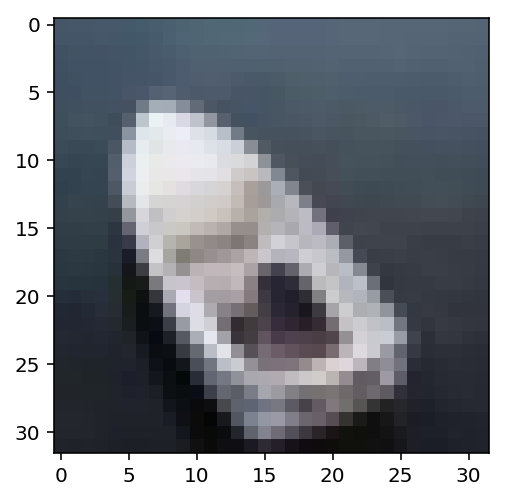

In [4]:
def load_batch(data_dir, batch_id):
    with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls

feats, labels = load_batch(cifar10_dir, 1)
cifar10_dir= 'cifar-10-batches-py'
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
sample_id = 1036
sample_img = feats[sample_id]
sample_lbl = labels[sample_id]
print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl]))
plt.imshow(sample_img)
print([sample_img.min(), sample_img.max(), sample_img.shape])

In [5]:
def load_batch(data_dir, batch_id):
    with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls
feats, labels = load_batch(cifar10_dir, 1)
def normalize(x):
    return x / 255.
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer().fit(range(10))

def one_hot_encode(x):
    global lb
    return lb.transform(x)
test_feats, test_lbls = [], []
for i in range(1, 6):
    feats, lbls = load_batch(cifar10_dir, i)
    test_size = int(len(feats) * 0.1)
    
    # training data
    norm_feats = normalize(feats[:-test_size])
    one_hot_lbls = one_hot_encode(lbls[:-test_size])
    pickle.dump((norm_feats, one_hot_lbls), open('preprocess_batch_%i.p' % i, 'wb'))
    
    # add the rest to the test data
    test_feats.extend(feats[-test_size:])
    test_lbls.extend(lbls[-test_size:])

# dump the test data too
norm_test_feats = normalize(np.array(test_feats))
one_hot_test_lbls = one_hot_encode(np.array(test_lbls))
pickle.dump((norm_test_feats, one_hot_test_lbls), open('preprocess_test.p', 'wb'))

In [6]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):

    # Weights
    W_shape = list(conv_ksize) + [int(x_tensor.shape[3]), conv_num_outputs]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    
    # Apply convolution
    x = tf.nn.conv2d(
        x_tensor, W,
        strides = [1] + list(conv_strides) + [1],
        padding = 'SAME'
    )
    
    # Add bias
    b = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.bias_add(x, b)
    
    # Nonlinear activation (ReLU)
    x = tf.nn.relu(x)
    
    # Max pooling
    return tf.nn.max_pool(
        x,
        ksize = [1] + list(pool_ksize) + [1],
        strides = [1] + list(pool_strides) + [1],
        padding = 'SAME'
    )
def flatten(x_tensor):
    
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape.as_list()[1:])])
def fully_conn(x_tensor, num_outputs):
    
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The fully connected layer
    x = tf.add(tf.matmul(x_tensor, W), b)
    
    # ReLU activation function
    return tf.nn.relu(x)

def output(x_tensor, num_outputs):
    
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The output layer
    return tf.add(tf.matmul(x_tensor, W), b)
def conv_net(x, keep_prob):
    
    # 3 convolution layers with max pooling
    # All layers with same kernel, stride and maxpooling params
    x = conv2d_maxpool(x, 64, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 256, (3,3), (1,1), (2,2), (2,2))
    
    # dropout after convolutions
    x = tf.nn.dropout(x, keep_prob)
    
    # flatten layer
    x = flatten(x)

    # 1 fully connected layer followed by dropout
    x = fully_conn(x, 1024)
    x = tf.nn.dropout(x, keep_prob)
    
    # output layer
    return output(x, 10)

In [7]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x
def one_hot_encode(x):

    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [9]:
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    
    global valid_features, valid_labels
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(
        accuracy, 
        feed_dict={
            x: norm_test_feats,
            y: one_hot_test_lbls,
            keep_prob: 1.
        }
    )
    print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(loss, valid_acc))
epochs = 30
batch_size = 1024
keep_probability = 0.5

def batch_features_labels(features, labels, batch_size):

    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):

    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


In [10]:
epochs = 30
print("Training...")
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches+1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(
                    optimizer, 
                    feed_dict={
                        x: batch_features, 
                        y: batch_labels, 
                        keep_prob: keep_probability
                    }
                )
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, './image_classification')

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:   2.1024, Validation Accuracy: 0.241200
Epoch  1, CIFAR-10 Batch 2:  Loss:   1.9128, Validation Accuracy: 0.344400
Epoch  1, CIFAR-10 Batch 3:  Loss:   1.7030, Validation Accuracy: 0.371800
Epoch  1, CIFAR-10 Batch 4:  Loss:   1.6181, Validation Accuracy: 0.409000
Epoch  1, CIFAR-10 Batch 5:  Loss:   1.5035, Validation Accuracy: 0.443600
Epoch  2, CIFAR-10 Batch 1:  Loss:   1.4437, Validation Accuracy: 0.474000
Epoch  2, CIFAR-10 Batch 2:  Loss:   1.4457, Validation Accuracy: 0.472400
Epoch  2, CIFAR-10 Batch 3:  Loss:   1.3158, Validation Accuracy: 0.496600
Epoch  2, CIFAR-10 Batch 4:  Loss:   1.2861, Validation Accuracy: 0.512600
Epoch  2, CIFAR-10 Batch 5:  Loss:   1.2377, Validation Accuracy: 0.537000
Epoch  3, CIFAR-10 Batch 1:  Loss:   1.2142, Validation Accuracy: 0.553200
Epoch  3, CIFAR-10 Batch 2:  Loss:   1.2324, Validation Accuracy: 0.548800
Epoch  3, CIFAR-10 Batch 3:  Loss:   1.1581, Validation Accuracy: 0.551600
Epoch  3, CIF

In [25]:
test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
loaded_graph = tf.Graph()
model_path = './image_classification'
n_samples = 4
top_n_predictions = 3
def batch_features_labels(features, labels, batch_size):
    
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7969735145568848



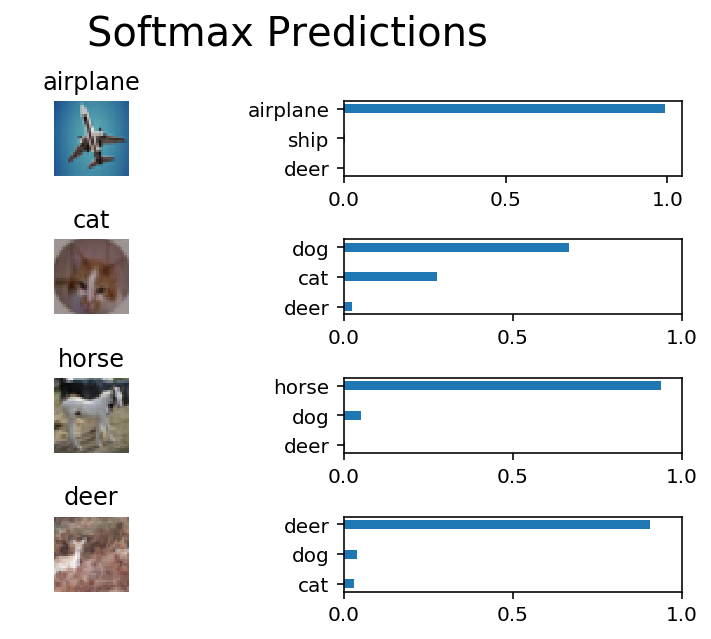

In [35]:
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
    # Get accuracy in batches for memory limitations
    test_batch_acc_total = 0
    test_batch_count = 0
    
    for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={
                loaded_x: test_feature_batch, 
                loaded_y: test_label_batch, 
                loaded_keep_prob: 1.0
            }
        )
        test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
    random_test_predictions = sess.run(
        tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        feed_dict={
            loaded_x: random_test_features, 
            loaded_y: random_test_labels, 
            loaded_keep_prob: 1.0
        }
    )
    display_image_predictions(random_test_features, random_test_labels, random_test_predictions)